**DATA PREPROCESSING**

**Input: raw data - Output: transactions**

In [ ]:
# First, we loaded the e-commerce dataset to google.colab from drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
!pwd

/content/gdrive/My Drive/Colab Notebooks


**1. Data Cleaning**

In [ ]:
# modules we'll use
import pandas as pd
import numpy as np

# read in all our data
ecommerce_data = pd.read_csv('data.csv', engine='python', parse_dates=['InvoiceDate'])

# set seed for reproducibility
np.random.seed(0)

In [ ]:
ecommerce_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# get the number of missing data points per column
missing_values_count = ecommerce_data.isnull().sum()
missing_values_count[:]

# total missing values
total_cells = np.product(ecommerce_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
percent_missing

3.149375633178264

In [ ]:
ecommerce_data["InvoiceDate"] = pd.to_datetime(ecommerce_data.InvoiceDate, cache=True)

ecommerce_data.InvoiceDate.max() - ecommerce_data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [ ]:
ecommerce_data["Revenue"] = ecommerce_data.Quantity * ecommerce_data.UnitPrice

ecommerce_data["Year"] = ecommerce_data.InvoiceDate.dt.year
ecommerce_data["Quarter"] = ecommerce_data.InvoiceDate.dt.quarter
ecommerce_data["Month"] = ecommerce_data.InvoiceDate.dt.week
ecommerce_data["Week"] = ecommerce_data.InvoiceDate.dt.week
ecommerce_data["Weekday"] = ecommerce_data.InvoiceDate.dt.weekday
ecommerce_data["Day"] = ecommerce_data.InvoiceDate.dt.day
ecommerce_data["Dayofyear"] = ecommerce_data.InvoiceDate.dt.dayofyear
#ecommerce_data['Date'] = pd.to_datetime(ecommerce_data[['Year', 'Month', 'Day']])
#ecommerce_data["Date"] = pd.to_datetime(ecommerce_data[['Year', 'Month', 'Day']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

In [ ]:
df = ecommerce_data.copy()
df.describe()

,Quantity,UnitPrice,CustomerID,Revenue,Year,Quarter,Month,Week,Weekday,Day,Dayofyear
count,541909.000000,541909.000000,406829.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15287.690570,17.987795,2010.921609,2.834723,30.729049,30.729049,2.431277,15.023096,213.613009
std,218.081158,96.759853,1713.600303,378.810824,0.268787,1.137261,15.146243,15.146243,1.844709,8.664063,106.174460
min,-80995.000000,-11062.060000,12346.000000,-168469.600000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,1.000000,1.250000,13953.000000,3.400000,2011.000000,2.000000,18.000000,18.000000,1.000000,7.000000,126.000000
50%,3.000000,2.080000,15152.000000,9.750000,2011.000000,3.000000,34.000000,34.000000,2.000000,15.000000,237.000000
75%,10.000000,4.130000,16791.000000,17.400000,2011.000000,4.000000,45.000000,45.000000,4.000000,22.000000,312.000000
max,80995.000000,38970.000000,18287.000000,168469.600000,2011.000000,4.000000,51.000000,51.000000,6.000000,31.000000,357.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


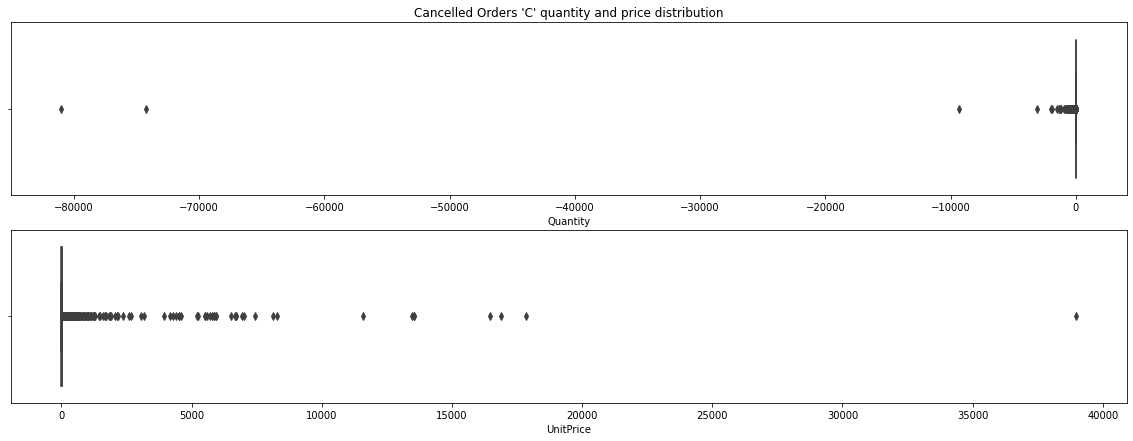

In [ ]:
fig,ax = plt.subplots(nrows=2,figsize=(20,7))
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['Quantity'],ax=ax[0])
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['UnitPrice'],ax=ax[1])
ax[0].title.set_text("Cancelled Orders 'C' quantity and price distribution")

In [ ]:
def check_hypothesis_cancelled_order(df):
  failed=0
  passed=0
  neg_qty=df[df["Quantity"]<0]
  pos_qty=df[df["Quantity"]>0]
  for ind in neg_qty.index:
    if(neg_qty['CustomerID'][ind]):
            p = pos_qty[
                (pos_qty['CustomerID'] == neg_qty['CustomerID'][ind])&
                (pos_qty['Quantity'] <= abs(neg_qty['Quantity'][ind]))&
                ((pos_qty['InvoiceDate'] - neg_qty['InvoiceDate'][ind]).dt.total_seconds()>=0)
            ]
            if(len(p)==0):
                failed+=1
            else:
                passed+=1
    if(failed>passed):
        print("Hypothesis Rejected!")
        print("Failed Counts:"+str(failed)+" Passed Counts:"+str(passed))
        print("Approximately "+str(int(failed/(failed + passed)*100)) + "% rows didn't satisfy the condition")

check_hypothesis_cancelled_order(df)

Hypothesis Rejected!
Failed Counts:79 Passed Counts:78
Approximately 50% rows didn't satisfy the condition


In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

%matplotlib inline

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Revenue      541909 non-null  float64       
 9   Year         541909 non-null  int64         
 10  Quarter      541909 non-null  int64         
 11  Month        541909 non-null  int64         
 12  Week         541909 non-null  int64         
 13  Weekday      541909 non-null  int64         
 14  Day          541909 non-null  int64         
 15  Dayofyear    541909 non-null  int6

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


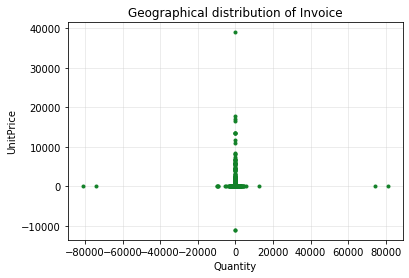

In [ ]:
_ = plt.plot(df['Quantity'], df['UnitPrice'], marker='.', linewidth=0, color='#128128')
_ = plt.grid(which='major', color='#cccccc', alpha=0.45)
_ = plt.title('Geographical distribution of Invoice', family='Arial', fontsize = 12)
_ = plt.xlabel('Quantity')
_ = plt.ylabel('UnitPrice')
_ = plt.show()

In [ ]:
#Prepare data for model
dbscan_data = df[['Quantity', 'UnitPrice']]
dbscan_data = dbscan_data.values.astype('float32', copy = False)
dbscan_data

array([[6.  , 2.55],
       [6.  , 3.39],
       [8.  , 2.75],
       ...,
       [4.  , 4.15],
       [4.  , 4.15],
       [3.  , 4.95]], dtype=float32)

In [ ]:
#Normalize data
dbscan_data_scaler = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scaler.transform(dbscan_data)
dbscan_data

array([[-0.01628867, -0.02130135],
       [-0.01628867, -0.01262006],
       [-0.00711777, -0.01923438],
       ...,
       [-0.02545958, -0.00476555],
       [-0.02545958, -0.00476555],
       [-0.03004503,  0.00350235]], dtype=float32)

In [ ]:
# Construct model
model = DBSCAN(eps = 0.25, min_samples= 12, metric ='euclidean').\fit(dbscan_data)
model

In [ ]:
models.labels_

NameError: ignored

In [ ]:
# Seperate outliers from clustered data
outliers_df = df[model.labels_ == -1]
clusters_df = df[model.labels_ != -1]

colors = model.labels_
colors_clusters = colors[colors != 1]
colors_outliers = 'black'

# Get info about the clusters
clusters = Counter(model.labels_)
print(clusters)
print(df[model.labels_ == -1].head())
print('Number of clusters = {}'.format(len(clusters) - 1))

NameError: ignored

In [ ]:
fig = plt.figure()

ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(clusters_df['Quantity'], clusters_df['UnitPrice'], c = colors_clusters, edgecolors='black', s=50)
ax.scatter(outliers_df['Quantity'], outliers_df['UnitPrice'], c = color_outliers, edgecolors='black', s=50)

ax.set_xlabel('Quantity',  family='Arial', fontsize=9)
ax.set_ylabel('UnitPrice', family='Arial', fontsize=9)

plt.title('Clustered Revenue by DBSCAN algorithm', family='Arial', fontsize=12)

plt.grid(which='major', color='#cccccc', alpha=0.45)

plt.show()